In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_text as text

In [2]:
import tensorflow_hub as hub

In [93]:
import sklearn
from official.nlp import optimization  # to create AdamW optimizer

In [3]:
factoid = pd.read_pickle("/app/home/heindlc/reddit_corpus_balanced_filtered.gzip", compression = "gzip")

In [4]:
factoid["pb_factor"].isnull().sum()

74

In [5]:
factoid = factoid[~ factoid["pb_factor"].isnull()]

In [6]:
factoid["pb_factor"].isnull().sum()

0

In [7]:
data = pd.concat([pd.DataFrame([[row[1], post[1],post[3], row[-4]] for post in row[3]], columns=["user_id", "post","topic","user_pb"])
                  for row in factoid.itertuples()], ignore_index=True)


In [8]:
data.shape


(3342802, 4)

In [9]:
data.head(1)

,user_id,post,topic,user_pb
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087


In [10]:
data_cats = data.copy()
data_cats["pb_categories"] = pd.cut(data_cats["user_pb"],
       [-3,-1.5,0,1.5,3], include_lowest=True,labels=["EXTREME_LEFT", "LEFT_CENTER","RIGHT_CENTER","EXTREME_RIGHT"])
data_cats

,user_id,post,topic,user_pb,pb_categories
0,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,The fact that this has to be explained is what...,r/politics,-0.826087,LEFT_CENTER
1,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"he's not deteriorating, he just does not care ...",r/politics,-0.826087,LEFT_CENTER
2,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"Look, it's now perfectly clear that if he coul...",r/politics,-0.826087,LEFT_CENTER
3,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,That's the whole point of this statement. Ther...,r/politics,-0.826087,LEFT_CENTER
4,ddf62a134f09db7a6056190d594bd41ff2f4cf04faf5db...,"I keep seeing that M4A is now just a ""bargaini...",r/politics,-0.826087,LEFT_CENTER
...,...,...,...,...,...
3342797,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,"They should say yes, that the debate is back o...",r/politics,-0.777778,LEFT_CENTER
3342798,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,Oil prices is so low... how is this even profi...,r/politics,-0.777778,LEFT_CENTER
3342799,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,No he wants to win to avoid prison and those c...,r/politics,-0.777778,LEFT_CENTER
3342800,265bde26afcab547a099f352a67bc462851b3d8b1b588c...,Obviously this is why we need a federal level ...,r/Coronavirus,-0.777778,LEFT_CENTER


/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

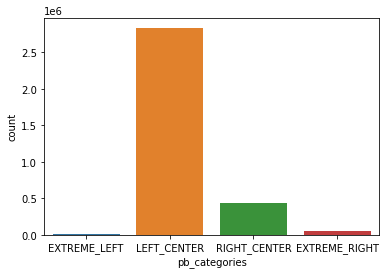

In [11]:
sns.countplot('pb_categories', data=data_cats)

In [12]:
class_counts = data_cats.pb_categories.value_counts()

c4 = data_cats[data_cats['pb_categories'] == "LEFT_CENTER"]
c3 = data_cats[data_cats['pb_categories'] == "RIGHT_CENTER"]
c2 = data_cats[data_cats['pb_categories'] == "EXTREME_LEFT"]
c1 = data_cats[data_cats['pb_categories'] == "EXTREME_RIGHT"]

In [13]:
class_counts

LEFT_CENTER      2836082
RIGHT_CENTER      440683
EXTREME_RIGHT      48958
EXTREME_LEFT       17079
Name: pb_categories, dtype: int64

In [14]:
c3 = c3.sample(class_counts["EXTREME_RIGHT"])   
c4 = c4.sample(class_counts["EXTREME_LEFT"])
data_balanced = pd.concat([c1,c2,c3,c4],axis=0 )

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_categories', ylabel='count'>

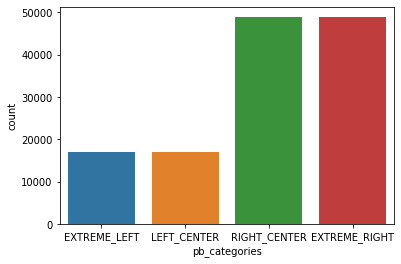

In [15]:
sns.countplot('pb_categories', data=data_balanced)

In [107]:
def binaryfy(label):
    if label in ["EXTREME_LEFT","EXTREME_RIGHT"]:
        return "1"
    else: 
        return "0"

In [108]:
data_binary = data_balanced.copy()
#df["Labels"] = df["Score"].apply(lambda score: map_score(score))
data_binary["pb_binary"] = data_binary["pb_categories"].apply(lambda label: binaryfy(label))

/app/home/heindlc/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pb_binary', ylabel='count'>

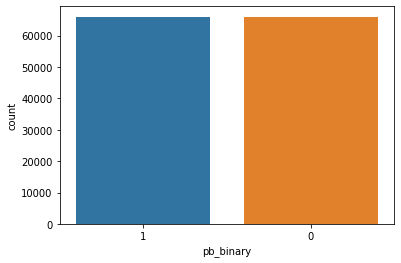

In [109]:
sns.countplot('pb_binary', data=data_binary)

In [19]:
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [20]:
! python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

/bin/bash: /app/home/heindlc/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [110]:
data_binary.head(3)

,user_id,post,topic,user_pb,pb_categories,pb_binary
61426,a76ed6c4f319b018700503a50c333028384bf7e9976796...,Biden is a horrible man. Straight up lying to...,r/Republican,3.0,EXTREME_RIGHT,1
61427,a76ed6c4f319b018700503a50c333028384bf7e9976796...,"The media,FBI, and the big banks, work for the...",r/Republican,3.0,EXTREME_RIGHT,1
61428,a76ed6c4f319b018700503a50c333028384bf7e9976796...,#NIGHTMARES,r/Republican,3.0,EXTREME_RIGHT,1


In [117]:
tf_data = data_binary[["post", "pb_binary"]]

In [112]:
#tf_data = tf.convert_to_tensor(tf_data)


In [118]:
tf_data


,post,pb_binary
61426,Biden is a horrible man. Straight up lying to...,1
61427,"The media,FBI, and the big banks, work for the...",1
61428,#NIGHTMARES,1
61429,That’s not even the bad video. Gnews.org is re...,1
61430,Wish the FBI would too. So much ignored corrup...,1
...,...,...
1077781,Which financial crime was he testifying about ...,0
3173639,"Anecdotal for sure, but enough anecdotes and t...",0
3138619,I pay a *little* attention to their trends. Bu...,0
634191,Everybody wants to go down in history as someo...,0


In [119]:
tf_data

,post,pb_binary
61426,Biden is a horrible man. Straight up lying to...,1
61427,"The media,FBI, and the big banks, work for the...",1
61428,#NIGHTMARES,1
61429,That’s not even the bad video. Gnews.org is re...,1
61430,Wish the FBI would too. So much ignored corrup...,1
...,...,...
1077781,Which financial crime was he testifying about ...,0
3173639,"Anecdotal for sure, but enough anecdotes and t...",0
3138619,I pay a *little* attention to their trends. Bu...,0
634191,Everybody wants to go down in history as someo...,0


## Convert to TensorFlow Dataset

In [161]:
tf_data = data_binary[["post", "pb_binary"]]
target = tf_data.pop("pb_binary")

#target = data_binary["pb_binary"]

#Post,labels = list(train["post"]), list(train.pop("pb_binary"))
#dataset = tf.data.Dataset.from_tensor_slices(Post, labels)



In [121]:
tf_data

,post
61426,Biden is a horrible man. Straight up lying to...
61427,"The media,FBI, and the big banks, work for the..."
61428,#NIGHTMARES
61429,That’s not even the bad video. Gnews.org is re...
61430,Wish the FBI would too. So much ignored corrup...
...,...
1077781,Which financial crime was he testifying about ...
3173639,"Anecdotal for sure, but enough anecdotes and t..."
3138619,I pay a *little* attention to their trends. Bu...
634191,Everybody wants to go down in history as someo...


In [162]:
target

61426      1
61427      1
61428      1
61429      1
61430      1
          ..
1077781    0
3173639    0
3138619    0
634191     0
2778939    0
Name: pb_binary, Length: 132074, dtype: object

In [167]:
target = np.asarray(target).astype('int32').reshape((-1,1))

In [168]:
target

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [154]:
tf_data


,post
61426,Biden is a horrible man. Straight up lying to...
61427,"The media,FBI, and the big banks, work for the..."
61428,#NIGHTMARES
61429,That’s not even the bad video. Gnews.org is re...
61430,Wish the FBI would too. So much ignored corrup...
...,...
1077781,Which financial crime was he testifying about ...
3173639,"Anecdotal for sure, but enough anecdotes and t..."
3138619,I pay a *little* attention to their trends. Bu...
634191,Everybody wants to go down in history as someo...


In [170]:
dataset = tf.data.Dataset.from_tensor_slices((tf_data.values, target))


In [171]:
for item in dataset.take(3):
    print(item)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Biden is a horrible man.  Straight up lying to the Americans. What a clown.'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'The media,FBI, and the big banks, work for the \xe2\x80\x9cbig guy\xe2\x80\x9d.  Nothing will happen. One big corrupt filthy family. Mexico\xe2\x80\x99s government seems like saints compared to these people.'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'#NIGHTMARES'], dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>)


## Split Dataset

In [172]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [173]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, len(dataset))

In [174]:
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [82]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder_loaded = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4",
    trainable=True)

In [176]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  # shape definition ? () = none ?
    preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(encoder_loaded, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [177]:
text_test = data["post"][1:2]
text_test

1    he's not deteriorating, he just does not care ...
Name: post, dtype: object

In [178]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.42457566]], shape=(1, 1), dtype=float32)


In [179]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [180]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [181]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [182]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/2
  7326/105659 [=>............................] - ETA: 2:05:09 - loss: 0.0246 - binary_accuracy: 0.9818

KeyboardInterrupt: 